In [3]:
import pysam
import os
from Bio import SeqIO
import pandas as pd
import tables
import h5py 
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from line_profiler import LineProfiler
import sys
sys.path.append('..//')

In [4]:
import shannon_entropies as se

In [3]:
def consensus_formatter(consensus_fasta_path):
    """
    consensus_formatter takes in a consensus fasta path, 
    and returns a dataframe containing the ids and sequences of all valid samples.

    Parameters:
    consensus_fasta_path: a path, as str, to the consensus fasta
    
    Returns:
    a pandas dataframe containing id and sequence.
    """

    # Set up list to hold consensus dictionaries
    valid_consensus_list = []

    # Search through the records in the fasta
    for record in SeqIO.parse(consensus_fasta_path, "fasta"):

        # For each record, get the header
        header = record.description

        # set the boundary conditions to invalid values before adding 'em
        cons_dict = {"start":None,"end":None, "id": None, "seq": None}

        # Check if there isn't a gap in the header
        if (not ('_Gap' in header)):

            # Get the boundary conditions by searching
            match = re.search(r'BC 1: (\d+), BC 2: (\d+)', header)
            
            # If the search has a match, add the indexes to the record
            if match:
                cons_dict["start"] = int(match.group(1))
                cons_dict["end"] = int(match.group(2))

            # add the id and sequence (with P swapped for G) to the dict
            cons_dict['id'] = str(record.id),
            cons_dict['seq'] = ''.join(record.seq.replace('P','G'))

            # add the dict to the valid consensus list
            valid_consensus_list.append(cons_dict)

    # convert the list of dicts to a dataframe
    df = pd.DataFrame(valid_consensus_list)
    
    # convert the ID from a weird touple to an actual value
    df[['id']] = pd.DataFrame(df['id'].tolist(), index=df.index)#3#######

    # return the dataframe
    return df

In [4]:
def get_record_indexes(consensus_path):
    """
    get_record_indexes takes in a path to a labeled consensus file, and returns a list
    containing dictionaries of the start and end indicies of the unknown region of the consensus.

    Parameters:
    consensus_path: path to consensus fasta (typically labeled_consensus.fasta) as a string

    Returns:
    list of dicts of indexes.
    
    """

    # Generate an empty list to hold the indexes 
    list_record_indexes = []

    # Loop through each record in the fasta file
    for record in SeqIO.parse(consensus_path, "fasta"):

        # For each record, get the header
        header = record.description

        # Get the boundary conditions by searching
        match = re.search(r'BC 1: (\d+), BC 2: (\d+)', header)

        # set the boundary conditions to invalid values before adding 'em
        idxs = {"start":-1,"end":-1}

        # If the search has a match, add the indexes to the record
        if match:
            idxs["start"] = int(match.group(1))
            idxs["end"] = int(match.group(2))
        list_record_indexes.append(idxs)

    # return the list of the record indexes
    return list_record_indexes

In [5]:
def load_in_data(samfile_path):
    """
    load_in_data takes in a path to a basecalled and aligned consensus samfile,
    and converts the data into a dataframe format.

    Parameters:
    sam_path: path, as str, to the basecalled and aligned consensus samfile.

    Returns:
    pandas dataframe of the relevant data. [sequence id, sequence, quality, length, reference index]
    """

    # Set an empty list to hold the data
    data_list = []

    # Open the samfile
    with pysam.AlignmentFile(samfile_path, 'r') as samfile:

        # Loop through each read in the samfile
        for read in samfile:

            # If the read is mapped, 
            if (not read.is_unmapped):

                # Get the sequence id, alignment sequence, cigar string, reference start position
                # and the quality, and put it into a dictionary
                sequence_id = read.query_name
                ref_name = read.reference_name
                seq = read.query_alignment_sequence
                cigar = read.cigartuples
                ref = read.reference_start
                quality = read.query_alignment_qualities
                rev = read.is_reverse
                tag_dict = dict(read.tags)
                read_dict = {'seq_id':sequence_id,
                             'ref_name':ref_name,
                             'sequence':seq,
                             'quality':list(quality),
                             'cigar':cigar,
                             'len':len(seq),
                             'ref':ref,
                             'rev':rev,
                             'moves':tag_dict['mv'],
                             'sig_len': tag_dict['ts'],
                             'trim_ofs':tag_dict['mv']}
                #if (ref == 0):

                # Append the dictionary to the data list
                data_list.append(read_dict)

    # convert the list of dicts into a dataframe
    #df = pd.DataFrame(data_list)

    # return the dataframe
    return data_list

In [6]:
def shift_sequence(sequence, ref, cigar):
    """
    shift_sequences takes in a sequence, corresponding quality, and reference position, and
    shifts it to align it with the proper positioning.

    Parameters:
    sequence: DNA read sequence as str.
    quality: DNA read qualities as list, same length of str.
    ref: reference position on the reference read, as int.
    cigar: the cigar string of the read, as str.

    returns:
    a dict of base positions with corresponding bases or insertions/deletions.
    """

    # Get the sequence as a list
    seq = list(sequence)

    # set current index to zero,
    # make a list to hold all of the operations.
    current_index = 0
    operations = []

    # set up an empty dict for the true sequence and qualities
    true_seq = {}
    true_quals = {}

    # for each index of an offset of a reference,
    # append 'S' to the operation sequence
    for i in range(ref):
        operations.append("S")

    # For each operation in the cigar,
    for operation in cigar:

        # Get the operation type and length
        op_type = operation[0]
        op_length = operation[1]

        # Loop through the operations
        for i in range(op_length):

            # If the operation isn't four or 5, 
            if (op_type != 4 and op_type != 5):

                # Append the operation to the list.
                operations.append(str(op_type))

    #print(''.join(seq))
    #print(''.join(operations))
    base_indexer = 0
    dels = 0
    for i in range(len(operations)-1):

        if (operations[i] == str(0)):
            #print(''.join(true_seq.values()))
            #print("Base Index: {}, Operation index: {}, Operation: {}".format(base_indexer, i, operations[i]))
            if (base_indexer in true_seq):
                true_seq[base_indexer] += seq[base_indexer]
            else:
                true_seq[base_indexer] = seq[base_indexer]
            base_indexer += 1
            
        elif (operations[i] == str(1)):
            if (base_indexer in true_seq):
                true_seq[base_indexer] += "+"
            else:
                true_seq[base_indexer] = "+"
                
        elif (operations[i] == str(2)):
            seq.insert(base_indexer, "-")
            if (base_indexer in true_seq):
                true_seq[base_indexer] += "-"
            else:
                true_seq[base_indexer] = "-"
            base_indexer += 1

        elif (operations[i] == "S"):
            seq.insert(base_indexer, "N")
            if (base_indexer in true_seq):
                true_seq[base_indexer] += ""
            else:
                true_seq[base_indexer] = ""
            base_indexer += 1
        
                
        # Delete the inserted base to shift everything over
        #del seq[index]
    
        # 3 - skipped region from reference
        # 4 - soft clipping
        # 5 - hard clipping
        # 6 - padding
        # 7 - sequence match
        # 8 - sequence mismatch

    # Return the sequence and the qualities
    return true_seq

In [7]:
def format_sequences(reads_df, indexes):
    """
    format_sequences takes in a dataframe of data previously exported from a sam file, and 
    indexes of the start and end of an unknown region, and returns the reads and quality scores for those segments.

    Parameters:
    reads_df: dataframe containing [sequence id, sequence, quality, length, reference index]
    indexes: a dictionary {"start", "end"} that contains the start and end indexes of an unknown region.

    Returns:
    a dataframe with rows indexed by read and columns by base position, containing strings
    of the corresponding bases at that location. 
    """

    #step 1: remedying insertions, deletions and alignment

    # Duplicate the reads dataframe
    l_df = reads_df.copy()

    # Shift each read using the shift_sequence method
    l_df['shift_dict'] = l_df.apply(lambda x: shift_sequence(x['sequence'],
                                                        x['ref'],
                                                        x['cigar']),
                               axis = 1)

    # Create new columns and split the shift touple column to two individual columns

    shift_bases_df = pd.DataFrame(l_df['shift_dict'].to_list())

    
    #Step 2, trimming off the ends

    # Trim the sequences and qualities
    if (indexes["start"] == None):
        indexes["start"] = 0
    if (indexes["end"] == None):
        indexes["end"] = len(shift_bases_df.columns)
    shift_bases_df = shift_bases_df.iloc[:, indexes["start"]:indexes["end"]]
    shift_bases_df.fillna('', inplace=True)
    

    # return the dataframe
    return shift_bases_df

In [8]:
def calc_base_probs(sequence_coordinates):
    """
    base_probs takes in a dataframe of base sequence coordinates and calculates the
    numerical probability of each base at each position by the number of occurences.

    Parameters:
    sequence_coordinates: A pandas dataframe where each row is a read, and each
                          column is a base position. Thus, each cell should have
                          a single base, as a string.

    Returns:
    a dataframe containing statistical likelyhoods of each base at a given position,
    with base positons as columns and base id's as rows. Has an extra column, n,
    that provides number of sample measurements in that row.
    """

    # Create a list to hold each option for a base
    base_options = ['A', 'G', 'C', 'T', '-', '+']

    # Generate an empty list to hold the probabilities
    list_of_prob_dicts = []
    list_of_obs = []

    # for each column,
    for column in list(sequence_coordinates.columns):
        
        # convert column to a list with each char being unique, positionally
        charlist = list(''.join(sequence_coordinates[column].to_list()))
        
        # convert the charlist to a pandas series
        char_series = pd.Series((x[0] for x in charlist))

        n_obs = len(char_series)
        list_of_obs.append(n_obs)
        
        # get the number of each value in the column as a dictionary
        counts_dict = char_series.value_counts().to_dict()

        # Loop through each option in the base options
        for option in base_options:

            # if the option isn't in the counts dictionary, set the value to zero
            if option not in counts_dict:
                counts_dict[option]=0

        # Sum up the amount of the base
        total = sum(counts_dict.values(), 0.0)

        probs_dict = {}

        # Add each base to the probability dictionaries
        for i in range(len(counts_dict)):
            key = list(counts_dict.keys())[i]
            value = list(counts_dict.values())[i]
            try:
                probs_dict[key] = value/total
            except:
                probs_dict[key] = None
            
        # append the probability dictionary of the bases to the list
        list_of_prob_dicts.append(probs_dict)

    # convert the list of dicts to a dataframe
    return_df = pd.DataFrame(list_of_prob_dicts)
    return_df['n']=pd.Series(list_of_obs)
    
    # Return the dataframe
    return return_df

In [9]:
def shannon_entropies(base_probs):
    """
    shannon_entropies takes in a dataframe with base options as columns and
    the base positions as rows, with the values being probability of each 
    base option at each position, and reuturns the shannon entropies
    of each position in the sequence.

    Parameters:
    base_probs: dataframe containing probabilities as described above

    Returns:
    a series of entropy at each position.
    """

    # Create a duplicate of the base probabilities so no overlapping
    # transforms. 
    tmp_df = base_probs.copy()

    # Set up a list for the base options
    base_options = ['A', 'G', 'C', 'T', '-', '+']

    n_col = tmp_df['n']
    tmp_df = tmp_df.drop(columns=['n'])
    tmp_df = tmp_df.fillna(value=np.nan)

    # loop through each base option in the probabilities
    for column in list(tmp_df.columns):

        # get the series of the column
        base_ser = tmp_df[column]

        # Compute the individual shannon entropy of the column
        tmp_df[column] = base_ser*np.log2(base_ser)

    # Sum all of the shannon entropies for each row, and *-1 to make them positive.
    entropy = tmp_df.sum(axis=1)*-1
    e_max = entropy.max()
    e_min = entropy.min()
    n_entropy = (entropy - e_min) / (e_max-e_min)

    # Return the entropy
    return entropy

In [10]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*800*t)*np.sin(2*np.pi*t) + np.sin(2*np.pi*400*t)
audio = Audio(audio_data, rate=framerate, autoplay=True)

bad_audio_data = np.sin(2*np.pi*800*t)+ np.sin(2*np.pi*700*t)
bad_audio = Audio(bad_audio_data, rate=framerate, autoplay=True)

def cmdnotify(status):
    if (status == 0):
        return audio
    else:
        return bad_audio
    
import warnings
warnings.filterwarnings("ignore")


In [11]:
form_consens = consensus_formatter(big_consensus_fasta)
loaded_data = load_in_data(big_bam_path)

NameError: name 'big_consensus_fasta' is not defined

In [12]:
def get_top_n_reads(cons_ids, read_ids, n=10):
    '''
    get_top_n_reads takes in a pandas series of alignment id's, and a pandas series of
    id's that reads aligned to (from a loaded bam or sam file),
    and returns a list of the ids of the top n alignments with the most corresponding
    reads.
    
    Parameters:
    cons_ids: pandas series of consensus sequence id's
    read_ids: pandas series of the ids a read aligned to
    n: int value (MUST BE LOWER THAN CONS_IDS LENGTH) of the top 
        number of reads desired. Default n = 10
        
    Returns:
    a series of the top n id's sorted by number of aligned reads, indexed by id
    '''
    
    # Get the number of instances of each alignment id in the reads
    count_series = read_ids.value_counts()
    
    # filter to make sure the reads in counts correspond to the consensus id's
    counts_in_alignment = count_series[count_series.index.isin(cons_ids)]
    
    # Get the top n id's
    n_counts = counts_in_alignment[:n]
    
    # return as a series indexed by read id
    return n_counts

In [13]:
e = get_top_n_reads(form_consens['id'], loaded_data['ref_name'])

NameError: name 'form_consens' is not defined

In [14]:
e.values

NameError: name 'e' is not defined

In [15]:
def wrapper(c_f, s_p, rev = None, n=10, savename = '../../../../'):
    form_consens = consensus_formatter(c_f)
    loaded_df = load_in_data(s_p)
    top_read_ids_series = get_top_n_reads(form_consens['id'], loaded_df['ref_name'], n=n)
    top_read_ids = list(top_read_ids_series.index)
    top_read_counts = list(top_read_ids_series.values)
    ent_data = []
    for i in range(len(top_read_ids)):
        print("{}/{} completed".format(i,len(top_read_ids)), end="\r")
        subset_df = loaded_df[loaded_df['ref_name'] == top_read_ids[i]]
        cons_seq = str((form_consens[form_consens['id'] == top_read_ids[i]]['seq'].values)[0])
        if (len(subset_df) >0):
            read_indexes = {'start':form_consens['start'][i], 'end':form_consens['end'][i]}
            
            # Get the series of booleans for if reversed
            reindexed_reverse = pd.Series(list(subset_df['rev'])) 
            
            formatted_df = format_sequences(subset_df, read_indexes)
            
            if (rev is not None):
                formatted_df = formatted_df[reindexed_reverse==rev]
            
            base_probs_df = calc_base_probs(formatted_df)

            shentropy_series = shannon_entropies(base_probs_df)

            ent_dict = {'alignment_id':form_consens['id'][i],
                        'sh_ent':list(shentropy_series),
                        'reads':top_read_counts[i]}
            
            '''
            Code for generating plots of counts
            fig, ax = plt.subplots(1,1, figsize = (20, 5))
            probcounts = base_probs_df[['A', 'G', 'C', 'T', '-', '+']].copy().multiply(base_probs_df["n"], axis="index")
            probcounts.plot.bar(ax=ax)
            ax.set_title('{}, read: {}'.format(savename.split('/')[-1], i))
            ax.grid(axis='y')
            ax.set_xlabel('Aligned Base at Position'.format(i))
            ax.set_ylabel('Count')
            ax.tick_params(axis='x',labelrotation=0)
            ax.set_xticklabels(list(cons_seq)[:-1])
            
            ax2 = ax.twinx()
            base_probs_df["n"].plot(ax=ax2, linewidth = 1, color='grey')
            ax2.set_ylabel('Total observations')
            fig.savefig('{}{}.png'.format(savename, i))
            '''
            
            ent_data.append(ent_dict)

    ent_df = pd.DataFrame(ent_data)
    
    return ent_df

In [11]:
big_consensus_fasta = "../../../data/reads_large/230725_PZ_lib_v4_r10/fasta/good.fa"
big_bam_path = "../../../data/large_working_directory/rough_consensus_output/large_align.bam"

consensus_fasta = "../../../data/working_directory/rough_consensus_output/xBSn_90mer_fake_randomer.fa"
bam_path_both = "../../../data/working_directory/rough_consensus_output/primary_read_filtered.bam"
bam_path_for = "../../../data/working_directory/rough_consensus_output/forward.bam"
bam_path_rev = "../../../data/working_directory/rough_consensus_output/reverse.bam"

'''
ent_df_for = wrapper(consensus_fasta, bam_path_for, None)
ent_df_rev = wrapper(consensus_fasta, bam_path_rev, None)
ent_df_both = wrapper(consensus_fasta, bam_path_both, None)
'''
ent_df_for = se.wrapper(big_consensus_fasta, big_bam_path, False, n=3) #savename = '../../../../forward')
ent_df_rev = se.wrapper(big_consensus_fasta, big_bam_path, True, n=3)#, savename = '../../../../reverse')
ent_df_both = se.wrapper(big_consensus_fasta, big_bam_path, None, n=3)#, savename = '../../../../all')

cmdnotify(0)

                                      seq_id  \
0       06afe0df-2d43-4fa9-bdb4-a6e3debbb196   
1       06c8e051-2570-4c0a-9b3f-5afb4bb57c5a   
2       06ecf4cf-91bd-4473-b850-866926ea9232   
3       038c50fb-6a93-43b6-bcec-25e1aef0eabc   
4       0af63547-53bb-4407-b4fb-a377b25558eb   
...                                      ...   
201675  fc55ca95-53ab-462b-ab1a-4552b6b62917   
201676  fce0c671-3810-4c7c-86df-e502efc1ad7c   
201677  fcd186c9-321c-48de-931c-9148224467f6   
201678  f9b8b6aa-032e-48a5-b431-1b1295658399   
201679  fc521a71-26f0-4e3b-bb62-37f195d14e9c   

                                                 ref_name  \
0       Pool=ACGTAACTTGGTTTGTTCCCTGAA-AGTCAGCT+CGAGGAG...   
1       Pool=CACCCACACTTACTTCAGGACGTA-AGTCAGCT+ACCTTGC...   
2       Pool=CAGGTTACTCCTCCGTGAGTCTGA-AGTCAGCT+CTAGATG...   
3       Pool=CATGTTCAACCAAGGCTTCTATGG-AGTCAGCT+ACCTTGC...   
4       Pool=CGACGGTTAGATTCACCTCTTACA-AGTCAGCT+ACGCAGG...   
...                                                   ...

/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                      seq_id  \
0       06afe0df-2d43-4fa9-bdb4-a6e3debbb196   
1       06c8e051-2570-4c0a-9b3f-5afb4bb57c5a   
2       06ecf4cf-91bd-4473-b850-866926ea9232   
3       038c50fb-6a93-43b6-bcec-25e1aef0eabc   
4       0af63547-53bb-4407-b4fb-a377b25558eb   
...                                      ...   
201675  fc55ca95-53ab-462b-ab1a-4552b6b62917   
201676  fce0c671-3810-4c7c-86df-e502efc1ad7c   
201677  fcd186c9-321c-48de-931c-9148224467f6   
201678  f9b8b6aa-032e-48a5-b431-1b1295658399   
201679  fc521a71-26f0-4e3b-bb62-37f195d14e9c   

                                                 ref_name  \
0       Pool=ACGTAACTTGGTTTGTTCCCTGAA-AGTCAGCT+CGAGGAG...   
1       Pool=CACCCACACTTACTTCAGGACGTA-AGTCAGCT+ACCTTGC...   
2       Pool=CAGGTTACTCCTCCGTGAGTCTGA-AGTCAGCT+CTAGATG...   
3       Pool=CATGTTCAACCAAGGCTTCTATGG-AGTCAGCT+ACCTTGC...   
4       Pool=CGACGGTTAGATTCACCTCTTACA-AGTCAGCT+ACGCAGG...   
...                                                   ...

/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                      seq_id  \
0       06afe0df-2d43-4fa9-bdb4-a6e3debbb196   
1       06c8e051-2570-4c0a-9b3f-5afb4bb57c5a   
2       06ecf4cf-91bd-4473-b850-866926ea9232   
3       038c50fb-6a93-43b6-bcec-25e1aef0eabc   
4       0af63547-53bb-4407-b4fb-a377b25558eb   
...                                      ...   
201675  fc55ca95-53ab-462b-ab1a-4552b6b62917   
201676  fce0c671-3810-4c7c-86df-e502efc1ad7c   
201677  fcd186c9-321c-48de-931c-9148224467f6   
201678  f9b8b6aa-032e-48a5-b431-1b1295658399   
201679  fc521a71-26f0-4e3b-bb62-37f195d14e9c   

                                                 ref_name  \
0       Pool=ACGTAACTTGGTTTGTTCCCTGAA-AGTCAGCT+CGAGGAG...   
1       Pool=CACCCACACTTACTTCAGGACGTA-AGTCAGCT+ACCTTGC...   
2       Pool=CAGGTTACTCCTCCGTGAGTCTGA-AGTCAGCT+CTAGATG...   
3       Pool=CATGTTCAACCAAGGCTTCTATGG-AGTCAGCT+ACCTTGC...   
4       Pool=CGACGGTTAGATTCACCTCTTACA-AGTCAGCT+ACGCAGG...   
...                                                   ...

/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'cmdnotify' is not defined

In [ ]:
ent_df_for

In [12]:
'''
fig, ax = plt.subplots(len(ent_df_both),1, figsize = (20, 5*(len(ent_df_for))))
plotting_ser_for = pd.Series(ent_df_for['sh_ent'][0])
base_indexes_for = list(plotting_ser_for.index)
for i in base_indexes_for:
    base_indexes_for[i] = str(base_indexes_for[i])
plotting_ser_rev = pd.Series(ent_df_rev['sh_ent'][0])
base_indexes_rev = list(plotting_ser_rev.index)
for i in base_indexes_rev:
    base_indexes_rev[i] = str(base_indexes_rev[i])
plotting_ser_both = pd.Series(ent_df_both['sh_ent'][0])
base_indexes_both = list(plotting_ser_both.index)
for i in base_indexes_both:
    base_indexes_both[i] = str(base_indexes_both[i])
ax[0].scatter(base_indexes_for, plotting_ser_for)
ax[1].scatter(base_indexes_rev, plotting_ser_rev)
ax[2].scatter(base_indexes_both, plotting_ser_both)
for i in range(len(ent_df_both)):
    ax[i].grid(axis='x')
    ax[i].tick_params(axis='x',labelrotation=-90)
    ax[i].set_xlabel("Base Index")
    ax[i].set_ylabel("Shannon Entropy")
    ax[i].set_ylim(0, 3.2)
    
fig.savefig('../../../../big_top1.png')
'''

'\nfig, ax = plt.subplots(len(ent_df_both),1, figsize = (20, 5*(len(ent_df_for))))\nplotting_ser_for = pd.Series(ent_df_for[\'sh_ent\'][0])\nbase_indexes_for = list(plotting_ser_for.index)\nfor i in base_indexes_for:\n    base_indexes_for[i] = str(base_indexes_for[i])\nplotting_ser_rev = pd.Series(ent_df_rev[\'sh_ent\'][0])\nbase_indexes_rev = list(plotting_ser_rev.index)\nfor i in base_indexes_rev:\n    base_indexes_rev[i] = str(base_indexes_rev[i])\nplotting_ser_both = pd.Series(ent_df_both[\'sh_ent\'][0])\nbase_indexes_both = list(plotting_ser_both.index)\nfor i in base_indexes_both:\n    base_indexes_both[i] = str(base_indexes_both[i])\nax[0].scatter(base_indexes_for, plotting_ser_for)\nax[1].scatter(base_indexes_rev, plotting_ser_rev)\nax[2].scatter(base_indexes_both, plotting_ser_both)\nfor i in range(len(ent_df_both)):\n    ax[i].grid(axis=\'x\')\n    ax[i].tick_params(axis=\'x\',labelrotation=-90)\n    ax[i].set_xlabel("Base Index")\n    ax[i].set_ylabel("Shannon Entropy")\n   

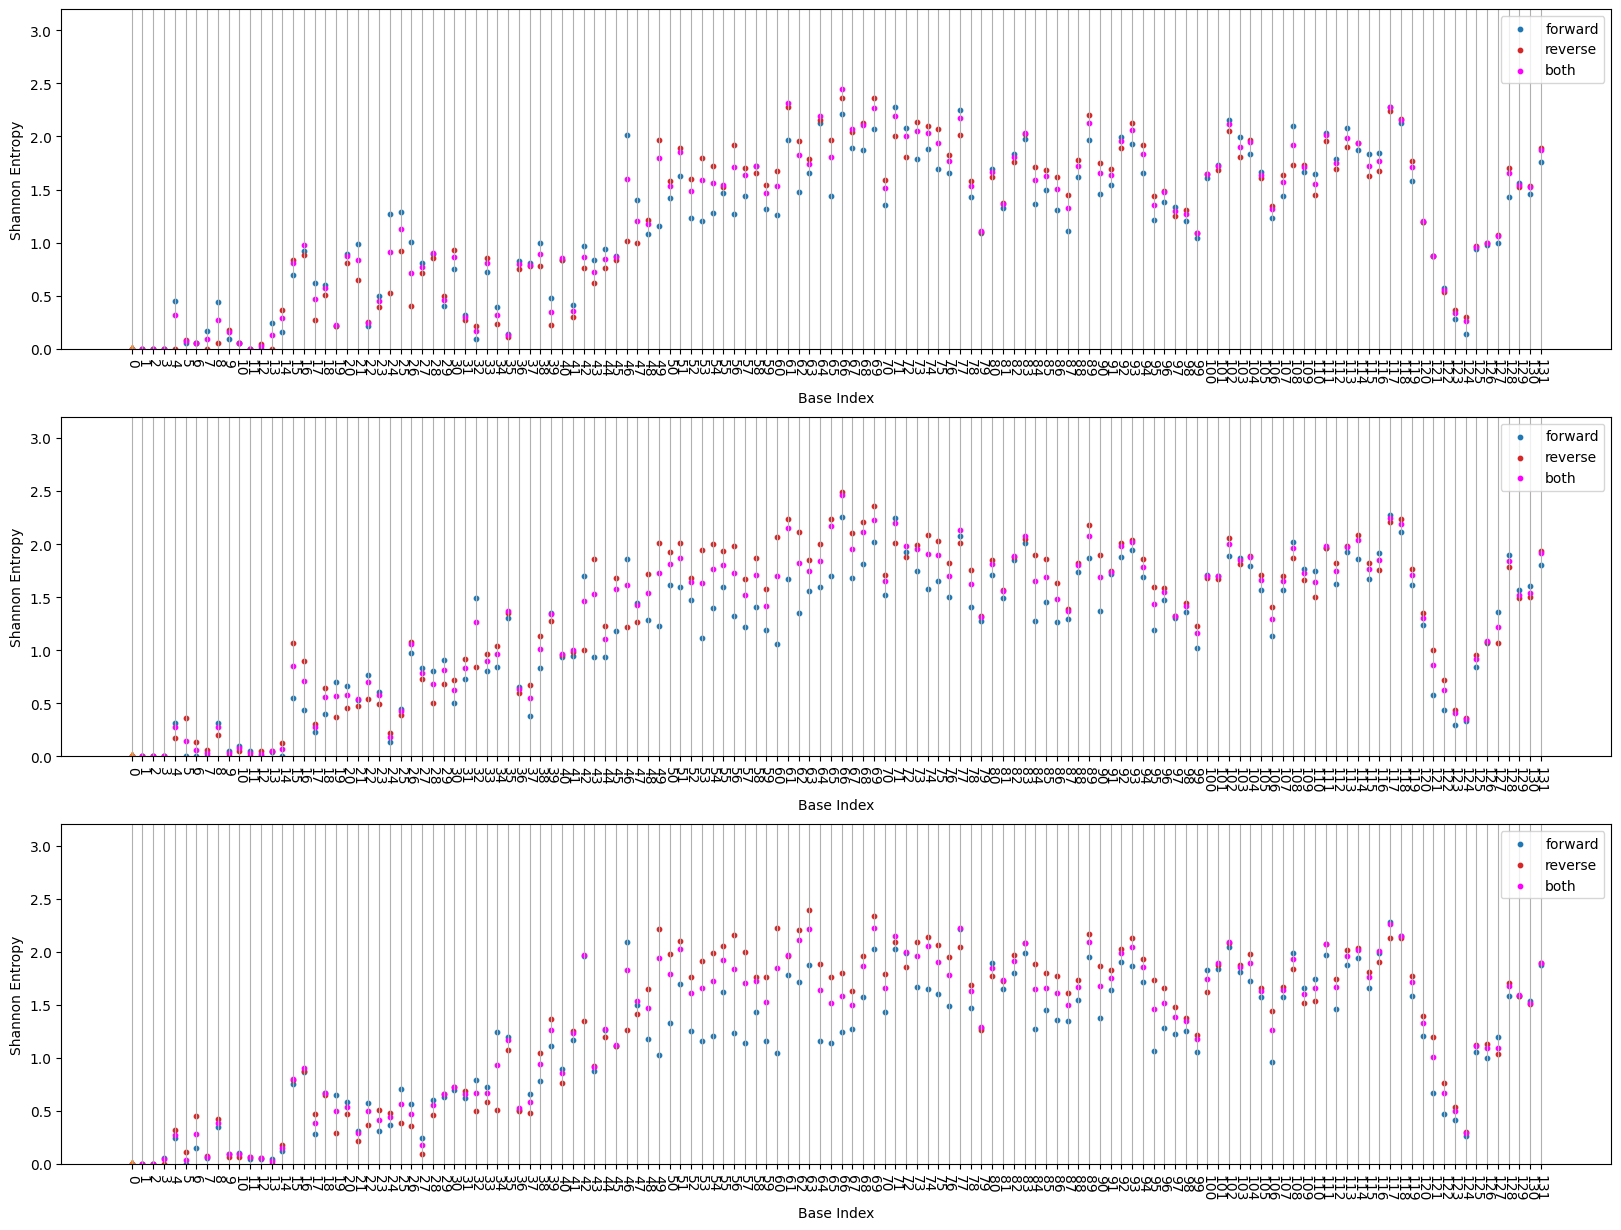

In [17]:
fig, ax = plt.subplots(len(ent_df_for),1, figsize = (20, 5*(len(ent_df_for))))

for i in range(len(ent_df_for)):
    
    
    plotting_ser_for = pd.Series(ent_df_for['sh_ent'][i])
    base_indexes_for = list(plotting_ser_for.index)
    
    for j in base_indexes_for:
        base_indexes_for[j] = str(base_indexes_for[j])
    
    plotting_ser_rev = pd.Series(ent_df_rev['sh_ent'][i])
    base_indexes_rev = list(plotting_ser_rev.index)
    
    for j in base_indexes_rev:
        base_indexes_rev[j] = str(base_indexes_rev[j])
    
    plotting_ser_both = pd.Series(ent_df_both['sh_ent'][i])
    base_indexes_both = list(plotting_ser_both.index)
    
    for j in base_indexes_both:
        base_indexes_both[j] = str(base_indexes_both[j])

    #print("alignment {}: \t n_reads forward: {}, n_reads reverse: {}, n_reads both: {}".format(i,
    #                                                                                           ent_df_for['reads'][i],ent_df_rev['reads'][i],
  #                                                                                             ent_df_both['reads'][i]))
    ax[i].scatter(x=base_indexes_for, y=plotting_ser_for, s=10, c='tab:blue')
    ax[i].scatter(x=base_indexes_rev, y=plotting_ser_rev, s=10, c='tab:red')
    ax[i].scatter(x=base_indexes_both, y=plotting_ser_both, s=10, c='magenta')
    ax[i].grid(axis="x")
    ax[i].scatter(x=[0, 0], y=[0, 0], marker = "^", c='tab:orange')
    #ax[i].set_title("Shannon entropy per base")
    ax[i].set_xlabel("Base Index")
    ax[i].set_ylabel("Shannon Entropy")
    ax[i].set_ylim(0, 3.2)
    ax[i].tick_params(axis='x',labelrotation=-90)
    ax[i].legend(['forward', 'reverse','both'])

In [ ]:
fig.savefig('../../../../big_top10.png')

In [ ]:
profiler = LineProfiler()
profiled_func = profiler(wrapper)
profiled_func(big_consensus_fasta, big_sam_path)
profiler.print_stats()
cmdnotify(0)

In [ ]:
ent_df

In [ ]:
fig, ax = plt.subplots(len(ent_df), 1, figsize = (15, 5*len(ent_df)))

for i in range(len(ent_df)):
    plotting_ser = pd.Series(ent_df['sh_ent'][i])
    base_indexes = list(plotting_ser.index)

    # Savgol filter parameters tuned through first barcode region fft
    sg = sig.savgol_filter(plotting_ser, 9, 3)
    for j in base_indexes:
        base_indexes[j] = str(base_indexes[j])

    ax.scatter(x=base_indexes, y=plotting_ser, s=10)
    ax.plot(base_indexes,sg, c="#4dc67c")
    ax.grid(axis="x")
    ax.scatter(x=[0, 0], y=[0, 0], marker = "^")
    ax.set_title("Shannon entropy per base")
    ax.set_xlabel("Base Index")
    ax.set_ylabel("Shannon Entropy")

#ps = np.abs(np.fft.fftshift(np.fft.fft(list(plotting_ser))))**2
#fx = np.arange(ps.shape[0]) - ps.shape[0]//2
#ax[1].plot(fx, ps)

#sgps = np.abs(np.fft.fftshift(np.fft.fft(list(sg))))**2
#ax[1].plot(fx, sgps)
#ax[1].set_xlim(0, 15)

    ax.legend(['True Entropy','Filtered Entropy','N-mer region indexers'])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10))


plotting_ser = shentropy_series
base_indexes = list(plotting_ser.index)

# Savgol filter parameters tuned through first barcode region fft
sg = sig.savgol_filter(plotting_ser, 9, 3)
for i in base_indexes:
    base_indexes[i] = str(base_indexes[i])

ax[0].scatter(x=base_indexes, y=plotting_ser, s=10)
ax[0].plot(base_indexes,sg, c="#4dc67c")
ax[0].grid(axis="x")
ax[0].scatter(x=[34, 56], y=[0, 0], marker = "^")
ax[0].set_title("Shannon entropy per base")
ax[0].set_xlabel("Base Index")
ax[0].set_ylabel("Shannon Entropy")

ps = np.abs(np.fft.fftshift(np.fft.fft(list(plotting_ser))))**2
fx = np.arange(ps.shape[0]) - ps.shape[0]//2
ax[1].plot(fx, ps)

sgps = np.abs(np.fft.fftshift(np.fft.fft(list(sg))))**2
ax[1].plot(fx, sgps)
ax[1].set_xlim(0, 15)

ax[0].legend(['True Entropy','Filtered Entropy','N-mer region indexers'])

In [ ]:
entr = se.file_shannon_entropy(sam_path, consensus_fasta, trimmed="N")
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
se.generate_shannon_plot(entr, ax)

In [ ]:
def threemer(x1, x2, x3):
    mean = (x1+x2+x3 / 3)
    std = np.sqrt(((x1-mean)**2 + (x2-mean)**2 + (x3-mean)**2) / 3)
    return mean, std

In [ ]:
def threemer_t_test(toup1, toup2):
    t = None
    if (toup1 != None):
        if (toup2 != None):
            t = (toup1[0] - toup2[0])/np.sqrt((toup1[1]**2 / 3) + (toup2[1]**2  /3))
    return t

In [ ]:
def find_ttest_threemers(qual_coords):
    """
    find_ttest_threemers takes in a quality coordinate dataframe (x being base, y being read number)
    and then finds the t-test values for each read in that dataset.

    Parameters:
    qual_coords: dataframe of base read qualities with column being read and row being base.

    Returns:
    a dataframe of threemers.
    """
    trans_qual_cord = qual_coords.T.copy()
    
    threemers = []
    for column in list(trans_qual_cord.columns):
        tmp = pd.DataFrame(columns=['base','up','down'])
        
        tmp['base'] = trans_qual_cord[column]
        tmp['up'] = trans_qual_cord[column].shift(-1)
        tmp['down'] = trans_qual_cord[column].shift(1)
    
        tmp['m_s_1']= tmp.apply(lambda x: threemer(x['base'], x['up'], x['down']), axis = 1)
    
        tmp['m_s_2'] = tmp['m_s_1'].shift(-1)
        
        threemer_ts = tmp.apply(lambda x: threemer_t_test(x['m_s_1'], x['m_s_2']), axis = 1)
        threemers.append({"read":column,"t_values":list(threemer_ts[1:-2])})
    return pd.DataFrame(threemers)

In [ ]:
three_t = find_ttest_threemers(quality_coordinate_df)

In [ ]:
t_coordinate_df = pd.DataFrame(three_t['t_values'].to_list())

In [ ]:
sums = []
means = []
stds = []
col_list = list(t_coordinate_df.columns)
string_columns = []
for column in col_list:
    sum = t_coordinate_df[column].sum()
    mean = t_coordinate_df[column].mean()
    std = t_coordinate_df[column].std()
    sums.append(sum)
    means.append(mean)
    stds.append(std)
    string_columns.append(str(column))

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
ax[0].scatter(string_columns, sums)
ax[0].grid(axis="x")

ax[1].grid(axis="x")
ax[1].errorbar(string_columns, means, np.array(stds), linestyle='None', marker='o', ecolor="tab:orange")
ax[1].set_title("Per-base t-test mean scores and standard deviations")
ax[1].set_xlabel("Base #")
ax[1].set_ylabel("mean t-test score")